In [1]:
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
%%bash


UsageError: %%bash is a cell magic, but the cell body is empty.


# Methodology: 
First, we calculate the "un-biasing" weights associated with each conformation sampled during the metadynamics simulation. In order to calculate these weights, we can use either of the two approaches: weights are calculated by considering the time-dependence of the metadynamics bias potential; Weights are calculated using the metadynamics bias potential obtained at the end of the simulation and assuming a constant bias during the entire course of the simulation. In this exercise we will use the umbrella-sampling-like reweighting approach (Method 2).To calculate the weights, we need to use the PLUMED driver utility and read the HILLS file along with the GROMACS trajectory file produced during the metadynamics simulation.

In [4]:
kbt=2.494339
minS=1.0
maxS=114.0
minS_actual=1.03
maxS_actual=112.9
nbin=25

### Evaluate bias on the full simulation

In [5]:
%%bash
plumed driver --plumed plumed.dat --mf_xtc abl1_md.xtc


DRIVER: Found molfile format trajectory xtc with name abl1_md.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:21:21
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/baoraa/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /home/baoraa/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 67927
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action RESTART
PLUMED:   with label @0
PLUMED:   MD code didn't require restart
PLUMED:   Switching on restart
PLUMED:   Restarting simulation: files will be appended
PLUMED: Action PATHMSD
PLUMED:   with label p1
PLUMED: Opening reference file path.pdb
PLUMED: 

In [6]:
data=pd.read_csv("COLVAR",sep="\s+", header=None, skiprows=1,usecols=[1,2,3]) 
data.columns=['s(R)','z(R)','bias']
data['s(R)']=data['s(R)'].round(2)
data

,s(R),z(R),bias
0,1.90,0.011533,149.325585
1,1.82,0.011707,148.022618
2,1.72,0.012545,147.008204
3,1.93,0.009537,143.402185
4,1.82,0.009520,141.415963
...,...,...,...
13329,90.42,0.026455,199.897369
13330,92.33,0.025622,198.335748
13331,94.45,0.024892,194.978573
13332,95.89,0.025026,192.737358


## Calculate Maximum bias

In [7]:
bmax=data['bias'].max()

# Calculate Boltzmann weights and write them to a file named "sR.weight"

In [8]:
data['weights']=np.exp((data['bias']-bmax)/kbt)
data.to_csv("sR.weight",index=False,sep="\t",columns=['s(R)','weights'])

## Calculate bin width

In [9]:
bin_width = round((maxS-minS)/float(nbin-1),2)
bin_width

4.71

# Block averaging

## Binning of data using cut: Create 20 equal-sized bins

In [10]:
weightdf=pd.read_csv('sR.weight',sep="\t")
weightdf.columns=['s(R)','weights']
weightdf['bin_index'] = pd.cut(weightdf['s(R)'],bins=nbin,labels=[i for i in range(nbin)]) 
weightdf

,s(R),weights,bin_index
0,1.90,3.688909e-12,0
1,1.82,2.187942e-12,0
2,1.72,1.456847e-12,0
3,1.93,3.432121e-13,0
4,1.82,1.547881e-13,0
...,...,...,...
13329,90.42,2.355348e-03,20
13330,92.33,1.259384e-03,20
13331,94.45,3.278185e-04,21
13332,95.89,1.334784e-04,21


In [11]:
bin_list=list(weightdf['bin_index'].unique())
bin_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [12]:
block_size = np.array([i for i in range(10,510,10)])
block_size

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])

In [13]:
nblocks = np.array(len(data)/block_size).astype(int)
len(nblocks)

50

In [14]:
xbar_xbarsq=[]
for i in range(0,len(nblocks)):
    xbar=pd.Series(index=bin_list,dtype=float,data=0)
    xbarsq=pd.Series(index=bin_list,dtype=float,data=0)
    for nblock in range(0, nblocks[i]):
        start = nblock * block_size[i]
        end = start + block_size[i]
        weightcopy=weightdf.copy()
        grp=weightcopy[start:end].groupby('bin_index')
        block_ave=grp['weights'].sum()/block_size[i]
        ind_list=list(block_ave.index)
        for ind in range(len(ind_list)):
            xbar[ind]+=block_ave[ind]
            xbarsq[ind]+=block_ave[ind]*block_ave[ind]
    xbar_xbarsq.append((nblocks[i],block_size[i],xbar,xbarsq))
        
length=len(xbar_xbarsq)
length

50

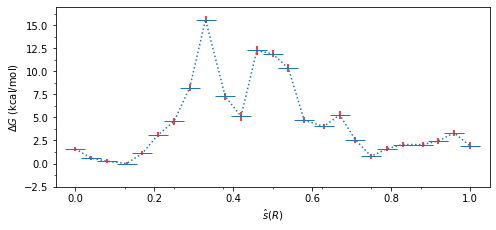

In [20]:
fig,ax=plt.subplots(figsize=(7,3.3))
sR_series = pd.Series(dtype=float,data=[(minS + (float(i) * bin_width)) for i in range(len(bin_list))])
for i in range(length):
    numblock=xbar_xbarsq[i][0]
    blocksize=xbar_xbarsq[i][1]
    result=pd.DataFrame()
    result['s(R)']=sR_series
    result['norm s(R)']=(result['s(R)']-minS)/(maxS-minS)
    result['Weight']=xbar_xbarsq[i][2]/blocksize
    result['Free Energy']=-kbt * np.log(result['Weight'])
    result['<x**2>']= (xbar_xbarsq[i][3]-result['Weight']**2)/(blocksize-1)
    result['error']=kbt*(np.sqrt(result['<x**2>']/blocksize))/result['Weight']
    
    outdf=result[['s(R)','norm s(R)','Free Energy','error']].copy()
    outdf['Free Energy']=(outdf['Free Energy']-outdf['Free Energy'].min())/4.184
    outdf['error']=outdf['error']/4.184
    outdf=outdf.round(2)
    outdf.to_csv(f'fes{blocksize}-np.dat',sep="\t",index=False)



ax.errorbar(x=outdf['norm s(R)'],y=outdf['Free Energy'],yerr=outdf['error'],ls='dotted',marker="_",markersize=20,ecolor='red')
ax.set_xlabel(r'$\hat s(R)$')
ax.set_ylabel('$\Delta$' '$\it{G}$' " (kcal/mol)")
ax.set_ylim([-2.5,17])

plt.rcParams['font.family'] = "sans-serif"

ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.125))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1.25))

plt.tight_layout()
plt.savefig("profile-non-phos.pdf",dpi=600)

### Error estimation
For each value of block length N, you will obtain a separate fesN.dat file, containing the value of the p1.sss variable on a grid, the average free-energy, and the associated error (in kJ/mol)
we can calculate the average error along the free-energy profile as a function of the block length


In [21]:
%%bash
echo > err.blocks
for i in {10..500..10}
do
 a=$(awk '{tot+=$4}END{print (tot/NR)}' fes"$i"-np.dat)
 echo $i $a >> err.blocks
done

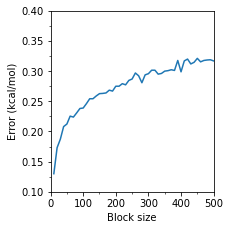

In [22]:
df=pd.read_csv("err.blocks",sep="\s+",header=None,skiprows=1)

fig,ax=plt.subplots(figsize=(3.3,3.3))


ax.plot(df[0],df[1])
ax.set_ylim([0.10,0.40])
ax.set_xlim([0,500])
ax.set_xlabel(r'Block size')
ax.set_ylabel('Error (kcal/mol)')

plt.rcParams['font.family'] = "sans-serif"

ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
plt.tight_layout()
plt.savefig("error-non-phos.pdf",dpi=600)